In [2]:
import spikeinterface.full as si
from probeinterface.plotting import plot_probe, plot_probegroup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec
from scipy import stats
import os
from Helpers import plot_utility
from P2_PostProcess.VirtualReality.plotting import get_vmin_vmax, min_max_normalize
from P2_PostProcess.VirtualReality.spatial_information import calculate_spatial_information

In [3]:
def plot_firing_rate_similarity_matrix(spike_data, vmax=1):

    firing_rate_matrix = []
    for cluster_index, cluster_id in enumerate(spike_data.cluster_id):
        cluster_df = spike_data[(spike_data.cluster_id == cluster_id)] # dataframe for that cluster
        firing_times_cluster = cluster_df.firing_times_vr.iloc[0]
        if len(firing_times_cluster)>1:
            cluster_firing_maps = np.array(cluster_df['fr_binned_in_space_smoothed'].iloc[0])
            cluster_firing_maps[np.isnan(cluster_firing_maps)] = 0
            cluster_firing_maps[np.isinf(cluster_firing_maps)] = 0
            cluster_firing_maps = min_max_normalize(cluster_firing_maps)
            firing_rate_matrix.append(cluster_firing_maps)
    
    firing_rate_matrix = np.array(firing_rate_matrix)

    similarity_matrix = np.zeros((len(cluster_firing_maps), len(cluster_firing_maps)))
    for i in np.arange(0, len(cluster_firing_maps)):
        for j in np.arange(0, len(cluster_firing_maps)):
            similarity_matrix[i,j] = stats.pearsonr(firing_rate_matrix[:,i,:].flatten(), firing_rate_matrix[:,j,:].flatten())[0]
            similarity_matrix[np.isnan(similarity_matrix)] = 0

    fig, ax = plt.subplots()
    im= ax.imshow(similarity_matrix, cmap="Greys", vmin=0, vmax=vmax)
    #ax.set_title("ID: "+str(cluster_id), fontsize= 25)
    ax.set_ylabel("Trial", fontsize=20)
    ax.set_xlabel("Trial", fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=10)
    fig.tight_layout()
    fig.colorbar(im, ax=ax)
    plt.show()

In [3]:
def get_data(vr_session_base_names, of_session_base_names):
    project_path = "/mnt/datastore/Harry/Cohort11_april2024/derivatives/"
    
    master_data = pd.DataFrame()
    for vr_name, of_name in zip(vr_session_base_names, of_session_base_names):
        mouse = vr_name.split("_")[0]
        day = vr_name.split("_")[1]
        vr_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/kilosort4/spikes.pkl"
        of_path = f"{project_path}{mouse}/{day}/of/{of_name}/processed/kilosort4/spikes.pkl"
        sorting_analyzer_path = f"{project_path}{mouse}/{day}/ephys/sorting_analyzer"
        spike_data_vr = pd.read_pickle(vr_path); spike_data_vr["firing_times_vr"] = spike_data_vr["firing_times"]
        spike_data_of = pd.read_pickle(of_path); spike_data_of["firing_times_of"] = spike_data_of["firing_times"]
        spike_data = pd.merge(spike_data_vr, spike_data_of, on="cluster_id")

        sorting_analyzer = si.load_sorting_analyzer(sorting_analyzer_path)
        ulc = sorting_analyzer.get_extension("unit_locations")
        unit_locations = ulc.get_data(outputs="by_unit")
        spike_data['unit_location_x'] = (spike_data.index.map(lambda unit: unit_locations[unit][0])*-1)+750+40
        spike_data['unit_location_y'] = spike_data.index.map(lambda unit: unit_locations[unit][1])
        spike_data['unit_location_z'] = spike_data.index.map(lambda unit: unit_locations[unit][2])

        position_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/position_data.csv"
        processed_position_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/processed_position_data.pkl"
        position_data = pd.read_csv(position_path)
        processed_position_data = pd.read_pickle(processed_position_path)

        spike_data = spike_data[(spike_data["snr_x"] > 1) & 
                                (spike_data["mean_firing_rate_x"] > 0.5) & 
                                (spike_data["rp_contamination_x"] < 0.9)]
        master_data = pd.concat([master_data, spike_data],ignore_index=True)
    return master_data

In [12]:
spike_data = get_data(vr_session_base_names =["M21_D26_2024-05-28_17-04-41_VR1"],
                      of_session_base_names = ["M21_D26_2024-05-28_16-35-31_OF1"])
mec_spike_data = spike_data[spike_data["unit_location_y"] < 2200]
v1_spike_data = spike_data[spike_data["unit_location_y"] > 2200]

plot_firing_rate_similarity_matrix(mec_spike_data, vmax=0.6)
plot_firing_rate_similarity_matrix(v1_spike_data, vmax=0.5)


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f19371e6860>>
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/envs/si/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f19371e6860>>
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/envs/si/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


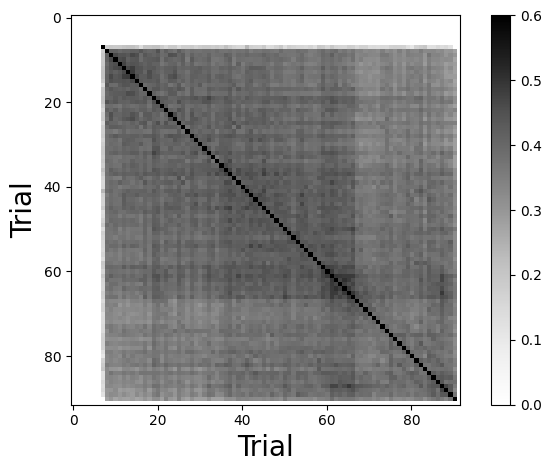

AssertionError: Extension unit_locations requires the recording

In [12]:
project_path = "/mnt/datastore/Harry/Cohort11_april2024/derivatives/"

of_session_base_names = ["M21_D15_2024-05-15_11-22-21_OF1",
                      "M21_D16_2024-05-16_14-03-05_OF1",
                      "M21_D17_2024-05-17_15-19-04_OF1", 
                      "M21_D18_2024-05-20_15-33-34_OF1",
                      "M21_D19_2024-05-21_15-30-20_OF1",
                      "M21_D20_2024-05-22_15-17-31_OF1",
                      "M21_D21_2024-05-23_15-50-21_OF1", 
                      "M21_D22_2024-05-24_15-31-28_OF1", 
                      "M21_D23_2024-05-25_16-07-17_OF1", 
                      "M21_D24_2024-05-26_15-58-23_OF1",
                      "M21_D25_2024-05-27_15-35-57_OF1", 
                      "M21_D26_2024-05-28_16-35-31_OF1"]

vr_session_base_names = ["M21_D15_2024-05-15_11-54-28_VR1",
                      "M21_D16_2024-05-16_14-40-02_VR1",
                      "M21_D17_2024-05-17_15-49-55_VR1", 
                      "M21_D18_2024-05-20_16-00-25_VR1",
                      "M21_D19_2024-05-21_15-55-06_VR1",
                      "M21_D20_2024-05-22_16-05-37_VR1",
                      "M21_D21_2024-05-23_16-16-08_VR1", 
                      "M21_D22_2024-05-24_16-04-58_VR1", 
                      "M21_D23_2024-05-25_16-54-12_VR1", 
                      "M21_D24_2024-05-26_16-35-19_VR1",
                      "M21_D25_2024-05-27_16-00-30_VR1", 
                      "M21_D26_2024-05-28_17-04-41_VR1"]

for vr_name, of_name in zip(vr_session_base_names, of_session_base_names):
    mouse = vr_name.split("_")[0]
    day = vr_name.split("_")[1]
    vr_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/kilosort4/spikes.pkl"
    of_path = f"{project_path}{mouse}/{day}/of/{of_name}/processed/kilosort4/spikes.pkl"
    sorting_analyzer_path = f"{project_path}{mouse}/{day}/ephys/sorting_analyzer"
    spike_data_vr = pd.read_pickle(vr_path); spike_data_vr["firing_times_vr"] = spike_data_vr["firing_times"]
    spike_data_of = pd.read_pickle(of_path); spike_data_of["firing_times_of"] = spike_data_of["firing_times"]
    spike_data = pd.merge(spike_data_vr, spike_data_of, on="cluster_id")

    sorting_analyzer = si.load_sorting_analyzer(sorting_analyzer_path)
    if "unit_locations" in sorting_analyzer.extensions:
        ulc = sorting_analyzer.get_extension("unit_locations")
        unit_locations = ulc.get_data(outputs="by_unit")
        spike_data['unit_location_x'] = (spike_data.index.map(lambda unit: unit_locations[unit][0])*-1)+750+40
        spike_data['unit_location_y'] = spike_data.index.map(lambda unit: unit_locations[unit][1])
        spike_data['unit_location_z'] = spike_data.index.map(lambda unit: unit_locations[unit][2])
        spike_data = spike_data[spike_data["unit_location_y"] < 2200] # remove v1 data 

    spike_data = spike_data[(spike_data["snr_x"] > 1) & 
                            (spike_data["mean_firing_rate_x"] > 0.5) & 
                            (spike_data["rp_contamination_x"] < 0.9)]

    plot_firing_rate_similarity_matrix(spike_data, vmax=0.6)


In [11]:
"unit_locations" not in sorting_analyzer.extensions

False